In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode, pearsonr

import json
import pymorphy2
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import matthews_corrcoef as bin_corr
from sklearn.metrics import log_loss

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.weightstats import _tconfint_generic as confint 

import catboost as cb
import lightgbm as lgb

# Necessary functions and classes

In [2]:
def custom_metric(y_true, y_pred):
    map_dict = {0 : -10, 1 : -0.1, 2 : 0.1, 3 : 0.5}
    weights = pd.Series(y_true).map(map_dict).values
    map_dict = {0 : -1, 1 : -1, 2 : 1, 3 : 1}
    y_pred_perfect = pd.Series(y_true).map(map_dict).values
    return sum(weights * y_pred)/sum(weights * y_true)

In [3]:
def normalize(text): 
    morph = pymorphy2.MorphAnalyzer()
    norm_text = []
    for word in text.split(" "):
        norm_word = morph.parse(word)[0].normal_form
        norm_text.append(norm_word)
        
    return " ".join(norm_text).strip()

In [4]:
def json_to_russian_text(data):
    data['russian_text'] = 0
    for i in data.index:
        story = data['story_json'][i]
        story = story.lower()
        for symbol in 'qazxswedcvfrtgbnhyujmkiolp"{}[],.:;1234567890-/?=_#«»\\%&()–₽—$²':
            story = story.replace(symbol, ' ')
        story = story.split()
        story = ' '.join(story)
        data.loc[i, 'russian_text'] = story
    return data

In [5]:
def get_name(story):
    parsed_story = json.loads(story.replace('\\\\"' , "'"))
    return parsed_story["properties"].get("name", "")

In [6]:
def story_num_pages(story):
    parsed_story = json.loads(story.replace('\\\\"' , "'"))
    return len(parsed_story["content"])

In [7]:
def mean_encode(df_train, df_test, column, n_splits=8):
    cv = TimeSeriesSplit(n_splits=n_splits)
    map_dict = {0 : "dislike", 1 : "skip", 2 : "view", 3 : "like"}
    
    for label in range(4):
        suffix = "_" + map_dict[label] + "_me"
        df_train[column + suffix] = np.nan
        df_train["mapped_event"] = np.where(df_train.event == label, 1, 0)
        
        ## apply encoding on train 
        for train_index, valid_index in cv.split(df_train):
            enc = df_train.loc[train_index, :].groupby(column).mapped_event.mean()
            df_train.loc[valid_index, column + suffix] = df_train.loc[valid_index, column].map(enc)
        
        ## apply encoding on test
        enc = df_train.groupby(column).mapped_event.mean()
        df_test[column + suffix] = df_test[column].map(enc)
    
        ## fill nans
        df_train[column + suffix].fillna(df_train.mapped_event.mean(), inplace=True)
        df_test[column + suffix].fillna(df_train.mapped_event.mean(), inplace=True)
    
        ## delete mapped event
        df_train.drop("mapped_event", axis=1, inplace=True)
    
    df_train[column + "_weighted_me"] = 0
    df_test[column + "_weighted_me"] = 0
    for weight, label in zip([-10, -0.1, 0.1, 0.5], list(range(4))):
        suffix = "_" + map_dict[label] + "_me"
        df_train[column + "_weighted_me"] += weight * df_train[column + suffix]
        df_test[column + "_weighted_me"] += weight * df_test[column + suffix]
    
    return df_train, df_test

In [8]:
def validate_model(model, X, y, cat_columns=[], n_splits=10, n_estimators=1, mean_num_leaves=30, 
                   print_process=True, verbose=False, weights=[-10, -0.1, 0.1, 0.5], random_mul=10):
    cv = TimeSeriesSplit(n_splits=n_splits)
    custom_scores, logloss_scores = [], []
    weights = np.array(weights).reshape(4, 1)
    stages_cnt = 0
    for train_index, valid_index in cv.split(X):
        if print_process:
            print("Stage number", stages_cnt)
        X_train, y_train = X.loc[train_index, :], y[train_index]
        X_valid, y_valid = X.loc[valid_index, :], y[valid_index]
        y_pred = np.zeros((len(X_valid), 4))
        for i in range(n_estimators):
            np.random.seed(i * random_mul)
            model.set_params(random_state = i * random_mul, 
                             num_leaves = mean_num_leaves + np.random.randint(-1, 2))
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      verbose=verbose,
                      early_stopping_rounds=20)
            y_pred_ = model.predict_proba(X_valid)
            y_pred += y_pred_
        y_pred = y_pred/n_estimators
        logloss_score = log_loss(y_valid, y_pred)
        y_pred = y_pred.dot(weights).reshape(len(X_valid))
        y_pred = np.where(y_pred > 0, 1, -1)
        custom_score = custom_metric(y_valid, y_pred)
        logloss_scores.append(logloss_score)
        custom_scores.append(custom_score)
        if print_process:
            print("Custom metric value:", custom_score, " logloss value:", logloss_score)
        stages_cnt += 1
            
    return np.array(custom_scores), np.array(logloss_scores)

In [9]:
def plot_importances(model, column_names, v_size=20):
    plt.figure(figsize=(15, v_size))
    FI = pd.DataFrame()
    FI["names"] = column_names
    FI["importances"] = model.feature_importances_
    sns.barplot(data=FI.sort_values(by="importances", ascending=False), 
               x="importances", y="names")
    plt.title("Feature importances")

# Parse data

## Reactions

In [10]:
train = pd.read_csv("stories_reaction_train.csv")
test = pd.read_csv("stories_reaction_test.csv")
train.rename(columns={"event_dttm" : "time"}, inplace=True)
test.rename(columns={"event_dttm" : "time"}, inplace=True)

## User info

In [11]:
customer_train = pd.read_csv("customer_train.csv")
customer_test = pd.read_csv("customer_test.csv")

## Story info

In [12]:
stories = json_to_russian_text(pd.read_csv("stories_description.csv"))

## Transactions

In [13]:
transactions = pd.read_csv("transactions.csv")

# Preprocessing

## Extract features from text

In [14]:
text_transformer = Pipeline([("vect", CountVectorizer()), 
                             ("svd", TruncatedSVD(n_components=10, random_state=0))])

In [15]:
%%time
stories["story_name"] = stories.story_json.apply(get_name)
#stories["russian_text"] = stories.russian_text.apply(normalize)
stories["story_num_pages"] = stories.story_json.apply(story_num_pages)

CPU times: user 672 ms, sys: 386 µs, total: 672 ms
Wall time: 673 ms


In [16]:
story_texts = text_transformer.fit_transform(stories.russian_text) 
text_columns = ["text_" + str(i) for i in range(10)]
for i, col in enumerate(text_columns):
    stories[col] = story_texts[:, i]    

In [17]:
text_transformer.get_params()["svd"].explained_variance_ratio_.sum()

0.28226961353105856

## Sort train and test by time

In [18]:
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)
train.sort_values(by="time", inplace=True)
test.sort_values(by="time", inplace=True)
train.set_index("time", inplace=True)
test.set_index("time", inplace=True)

In [19]:
## train
train["month"] = train.index.month
train.month = train.month.astype(np.int8)
train["day"] = train.index.day
train.day = train.day.astype(np.int8)
train["hour"] = train.index.hour
train.hour = train.hour.astype(np.int8)
train["minute"] = train.index.minute
train.minute = train.minute.astype(np.int8)
train["second"] = train.index.second
train.second = train.second.astype(np.int8)
train["weekday"] = train.index.weekday
train.weekday = train.weekday.astype(np.int8)

## test
test["month"] = test.index.month
test.month = test.month.astype(np.int8)
test["day"] = test.index.day
test.day = test.day.astype(np.int8)
test["hour"] = test.index.hour
test.hour = test.hour.astype(np.int8)
test["minute"] = test.index.minute
test.minute = test.minute.astype(np.int8)
test["second"] = test.index.second
test.second = test.second.astype(np.int8)
test["weekday"] = test.index.weekday
test.weekday = test.weekday.astype(np.int8)

## Merge train/test with user info 

In [20]:
train = pd.merge(train, customer_train, on=["customer_id"], how="left")
test = pd.merge(test, customer_test, on=["customer_id"], how="left")

## Merge train/test with story info

In [21]:
train = pd.merge(train, stories.drop("story_json", axis=1), on=["story_id"], how="left")
test = pd.merge(test, stories.drop("story_json", axis=1), on=["story_id"], how="left")

## Merge train/test with transactions

In [22]:
g = transactions.groupby("customer_id").agg({"transaction_amt" : ["mean", "std", "count"], 
                                             "merchant_mcc" : [lambda x: mode(x)[0], lambda x: x.nunique()], 
                                             "transaction_month" : lambda x : x.nunique()}).reset_index()
g.columns = ['_'.join(col).strip("_") for col in g.columns.values]
g.rename(columns={"merchant_mcc_<lambda_0>" : "favourite_mcc", 
                  "merchant_mcc_<lambda_1>" : "mcc_nunique", 
                  "transaction_month_<lambda>" : "n_months", 
                  "transaction_amt_count" : "transaction_amt_cnt"}, inplace=True)

train = pd.merge(train, g, on="customer_id", how="left")
test = pd.merge(test, g, on="customer_id", how="left")

In [23]:
g = transactions.groupby(["customer_id", "merchant_mcc"]).agg({"transaction_amt" : "mean"}).reset_index()
g.rename(columns={"merchant_mcc" : "favourite_mcc", "transaction_amt" : "amt_on_favourite_mean"}, inplace=True)
train = pd.merge(train, g, on=["customer_id", "favourite_mcc"], how="left")
test = pd.merge(test, g, on=["customer_id", "favourite_mcc"], how="left")

## Preprocessing of categorical features

In [24]:
cat_columns = ["gender_cd", "marital_status_cd", "job_title", "job_position_cd", "favourite_mcc"]
le = LabelEncoder()
for col in cat_columns:
    train[col] = train[col].astype("str")
    test[col] = test[col].astype("str")
    train[col].fillna("NaN", inplace=True)
    test[col].fillna("NaN", inplace=True)
    le.fit(pd.concat([train[col], test[col]], axis=0))
    train[col] = le.transform(train[col]).astype(np.int32)
    test[col] = le.transform(test[col]).astype(np.int32)

In [25]:
product_columns = ["product_" + str(i) for i in range(7)]
for col in product_columns:
    train[col] = train[col].astype("str")
    test[col] = test[col].astype("str")
    train[col].fillna("NaN", inplace=True)
    test[col].fillna("NaN", inplace=True)

In [26]:
train.event = train.event.map({"dislike" : 0, "skip" : 1, "view" : 2, "like" : 3}).astype(np.int8)

## Preprocessing of numerical features

In [28]:
num_columns = ["month", "day", "hour", "minute", "second", "age", "children_cnt", 
               "transaction_amt_mean", "transaction_amt_std", "transaction_amt_cnt", 
               "amt_on_favourite_mean", "story_num_pages", "mcc_nunique"]
for col in num_columns:
    train[col].fillna(-1, inplace=True)
    train[col] = train[col].astype(np.float16)
    test[col].fillna(-1, inplace=True)
    test[col] = test[col].astype(np.float16)

In [29]:
train.n_months.fillna(train.n_months.min(), inplace=True)
test.n_months.fillna(train.n_months.min(), inplace=True)

## Preprocessing of text features

In [30]:
for col in text_columns:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(train[col].median(), inplace=True)

# Feature generation

## Customer-based

In [31]:
for name in ["CLS", "UTL", "OPN"]:
    func = lambda x: 1 if x == name else 0
    train["num_products_" + name] = train[product_columns].applymap(func).sum(axis=1)
    test["num_products_" + name] = test[product_columns].applymap(func).sum(axis=1) 

In [32]:
customer_clusters = pd.read_csv("customer_cluster.csv").rename(columns={"label" : "customer_cluster"})
train = pd.merge(train, customer_clusters, on="customer_id", how="left")
test = pd.merge(test, customer_clusters, on="customer_id", how="left")

In [33]:
train.customer_cluster.fillna(-1, inplace=True)
train.customer_cluster = train.customer_cluster.astype(np.int8)
test.customer_cluster.fillna(-1, inplace=True)
test.customer_cluster = test.customer_cluster.astype(np.int8)

## Story-based

In [34]:
story_clusters = pd.read_csv("story_label.csv") 
train = pd.merge(train, story_clusters, on="story_id", how="left")
test = pd.merge(test, story_clusters, on="story_id", how="left")

In [35]:
train.story_cluster.fillna(-1, inplace=True)
train.story_cluster = train.story_cluster.astype(np.int8)
test.story_cluster.fillna(-1, inplace=True)
test.story_cluster = test.story_cluster.astype(np.int8)

In [36]:
train["story_name_length"] = train.story_name.astype(str).apply(len)
test["story_name_length"] = test.story_name.astype(str).apply(len)

## Lags

In [37]:
train["previous_story_cluster"] = train.groupby("customer_id").story_cluster.transform(lambda x: x.shift(periods=1))
test["previous_story_cluster"] = test.groupby("customer_id").story_cluster.transform(lambda x: x.shift(periods=1))
train.previous_story_cluster.fillna(-1, inplace=True)
train.previous_story_cluster = train.previous_story_cluster.astype(np.int8)
test.previous_story_cluster.fillna(-1, inplace=True)
test.previous_story_cluster = test.previous_story_cluster.astype(np.int8)

## Interactions

In [38]:
le = LabelEncoder()

train["pair_id"] = train.customer_id.astype(str) + "_" + train.story_id.astype(str)
test["pair_id"] = test.customer_id.astype(str) + "_" + test.story_id.astype(str)
le.fit(pd.concat([train.pair_id, test.pair_id], axis=0))
train["pair_id"] = le.transform(train.pair_id)
test["pair_id"] = le.transform(test.pair_id)

In [39]:
train["story_cluster_favourite_mcc"] = train.story_cluster.astype(str) + "_" + train.favourite_mcc.astype(str)
test["story_cluster_favourite_mcc"] = test.story_cluster.astype(str) + "_" + test.favourite_mcc.astype(str)
le.fit(pd.concat([train.story_cluster_favourite_mcc, test.story_cluster_favourite_mcc], axis=0))
train["story_cluster_favourite_mcc"] = le.transform(train.story_cluster_favourite_mcc)
test["story_cluster_favourite_mcc"] = le.transform(test.story_cluster_favourite_mcc)

In [40]:
train["story_cluster_job_title"] = train.story_cluster.astype(str) + "_" + train.job_title.astype(str)
test["story_cluster_job_title"] = test.story_cluster.astype(str) + "_" + test.job_title.astype(str)
le.fit(pd.concat([train.story_cluster_job_title, test.story_cluster_job_title], axis=0))
train["story_cluster_job_title"] = le.transform(train.story_cluster_job_title)
test["story_cluster_job_title"] = le.transform(test.story_cluster_job_title)

In [41]:
train["story_cluster_gender_cd"] = train.story_cluster.astype(str) + "_" + train.gender_cd.astype(str)
test["story_cluster_gender_cd"] = test.story_cluster.astype(str) + "_" + test.gender_cd.astype(str)
le.fit(pd.concat([train.story_cluster_gender_cd, test.story_cluster_gender_cd], axis=0))
train["story_cluster_gender_cd"] = le.transform(train.story_cluster_gender_cd)
test["story_cluster_gender_cd"] = le.transform(test.story_cluster_gender_cd)

In [42]:
mean_age_on_cluster = pd.concat([train, test], axis=0, sort=False).groupby("story_cluster").age.mean()
train["mean_age_on_cluster"] = train.story_cluster.map(mean_age_on_cluster)
test["mean_age_on_cluster"] = test.story_cluster.map(mean_age_on_cluster)

In [43]:
train["amt_per_month_mean"] = train.transaction_amt_mean / train.n_months
test["amt_per_month_mean"] = test.transaction_amt_mean / test.n_months

## Counters

In [44]:
customer_cnt = pd.concat([train, test], axis=0, sort=False).groupby("customer_id").customer_id.count()
train["customer_cnt"] = train.customer_id.map(customer_cnt)
test["customer_cnt"] = test.customer_id.map(customer_cnt)

In [45]:
story_cnt = pd.concat([train, test], axis=0, sort=False).groupby("story_id").story_id.count()
train["story_cnt"] = train.story_id.map(story_cnt)
test["story_cnt"] = test.story_id.map(story_cnt)

In [46]:
story_cluster_cnt = pd.concat([train, test], axis=0, sort=False).groupby("story_cluster").story_cluster.count()
train["story_cluster_cnt"] = train.story_cluster.map(story_cluster_cnt)
test["story_cluster_cnt"] = test.story_cluster.map(story_cluster_cnt)

In [47]:
previous_story_cluster_cnt = pd.concat([train, test], 
                                       axis=0, 
                                       sort=False).groupby("previous_story_cluster").previous_story_cluster.count()
train["previous_story_cluster_cnt"] = train.story_cluster.map(previous_story_cluster_cnt)
test["previous_story_cluster_cnt"] = test.story_cluster.map(previous_story_cluster_cnt)

In [48]:
pair_cnt = pd.concat([train, test], axis=0, sort=False).groupby("pair_id").pair_id.count()
train["pair_cnt"] = train.pair_id.map(pair_cnt)
test["pair_cnt"] = test.pair_id.map(pair_cnt)

## Mean_encoding

In [49]:
train, test = mean_encode(train, test, "customer_id")
train, test = mean_encode(train, test, "story_id")
train, test = mean_encode(train, test, "pair_id")
train, test = mean_encode(train, test, "story_num_pages")

## Choose final features

In [50]:
## categorical
final_cat_columns = ["story_cluster", "story_cluster_favourite_mcc", "previous_story_cluster"]

## numerical
final_num_columns = ["hour", "weekday", "age", "children_cnt",  
                     "transaction_amt_std", "transaction_amt_cnt", "amt_on_favourite_mean", 
                     "customer_cnt", "story_cnt", "pair_cnt", "story_cluster_cnt",
                     "mean_age_on_cluster", 
                     "story_name_length", "story_num_pages",
                     "story_id_dislike_me", "story_id_like_me", "story_id_view_me", "story_id_skip_me", 
                     "customer_id_dislike_me", "customer_id_like_me", "customer_id_view_me", "customer_id_skip_me",
                     "pair_id_dislike_me", "pair_id_like_me",
                     "story_num_pages_skip_me",
                     "story_num_pages_like_me", "story_num_pages_dislike_me"]

# Modelling

In [53]:
X_train = train[final_cat_columns + final_num_columns]
y_train = train.event
X_test = test[final_cat_columns + final_num_columns]
mean_num_leaves = 30
lgb_clf = lgb.LGBMClassifier(n_estimators=80,
                            num_class=4,
                            objective="multiclass",
                            boosting_type="gbdt",
                            learning_rate=0.1,
                            depth=6,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            reg_alpha=0.5,
                            reg_lambda=0.5,
                            num_leaves=mean_num_leaves, 
                            random_state=42)

In [54]:
X_train.shape, X_test.shape

((473141, 30), (172049, 30))

## Tune parameters

%%time
depth_list = [6]
num_leaves_list = [25, 27, 29, 31, 33, 35]
scores_matrix = np.zeros((len(depth_list), len(num_leaves_list)))
for i in range(len(depth_list)):
    for j in range(len(num_leaves_list)):
        depth, num_leaves = depth_list[i], num_leaves_list[j]
        print("Depth:", depth, " num_leaves:", num_leaves)
        lgb_clf.set_params(depth=depth, num_leaves=num_leaves)
        custom_scores, logloss_scores = validate_model(lgb_clf, X_train, y_train, 
                                n_splits=5, n_estimators=5,
                                verbose=False, 
                                print_process=False)
        scores_matrix[i, j] = custom_scores.mean() 
        print(custom_scores.mean(), custom_scores.std())

## Validate

In [55]:
%%time
custom_scores, logloss_scores = validate_model(lgb_clf, X_train, y_train, 
                                               n_splits=10, verbose=False,
                                               n_estimators=5, 
                                               random_mul=10,
                                               mean_num_leaves=mean_num_leaves)

Stage number 0
Custom metric value: 0.3177512908200985  logloss value: 0.9564143728876419
Stage number 1
Custom metric value: 0.3639101409161519  logloss value: 0.8552860780796345
Stage number 2
Custom metric value: 0.42015869533423766  logloss value: 0.8220789049655578
Stage number 3
Custom metric value: 0.4152513540105749  logloss value: 0.8305592356143651
Stage number 4
Custom metric value: 0.45923386628820306  logloss value: 0.8394244838366667
Stage number 5
Custom metric value: 0.3935281743722933  logloss value: 0.8391558533023773
Stage number 6
Custom metric value: 0.47141655633003  logloss value: 0.8396569820391083
Stage number 7
Custom metric value: 0.5246406257160933  logloss value: 0.8759601579818306
Stage number 8
Custom metric value: 0.5306170541178169  logloss value: 0.8096070560220309
Stage number 9
Custom metric value: 0.47071337398969104  logloss value: 0.744562239688505
CPU times: user 26min 31s, sys: 13.8 s, total: 26min 45s
Wall time: 22h 13min 48s


In [56]:
print("Mean: ", custom_scores.mean())
print("Confidence_interval:" , confint(custom_scores.mean(), custom_scores.std(ddof=1)/np.sqrt(len(custom_scores)), 
                                       len(custom_scores) - 1, alpha=0.05, alternative="two-sided"))

Mean:  0.43672211318951903
Confidence_interval: (0.38816411911491333, 0.48528010726412474)


In [57]:
print("Mean: ", logloss_scores.mean())
print("Confidence_interval:" , confint(logloss_scores.mean(), logloss_scores.std(ddof=1)/np.sqrt(len(logloss_scores)), 
                                       len(logloss_scores) - 1, alpha=0.05, alternative="two-sided"))

Mean:  0.8412705364417719
Confidence_interval: (0.8031878949264274, 0.8793531779571163)


## Plot feature importances

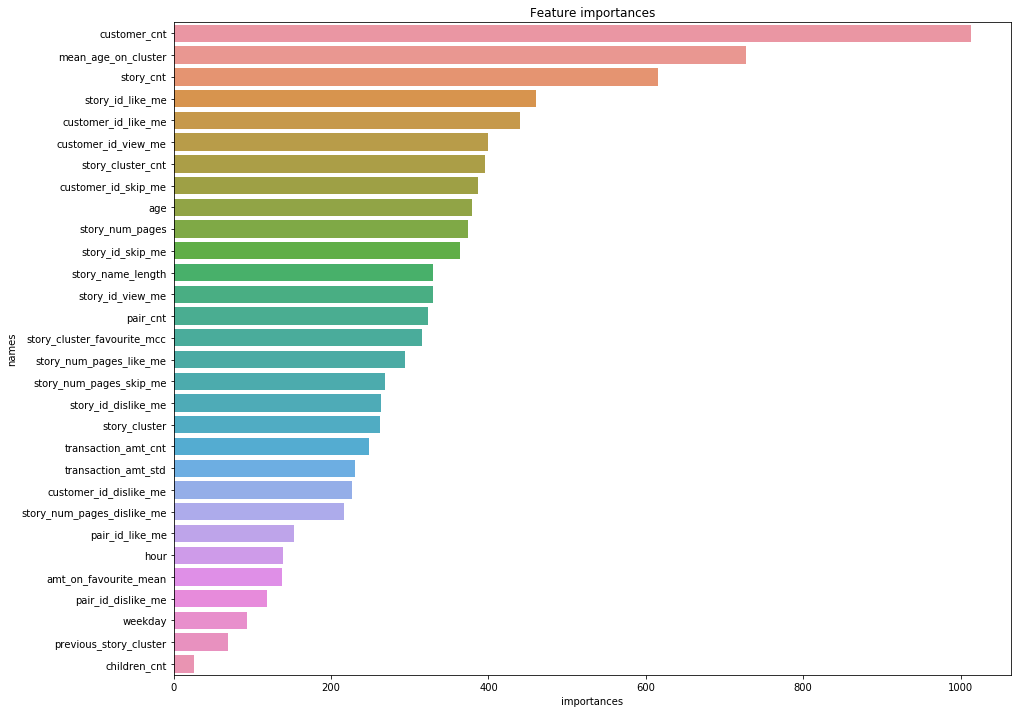

In [58]:
plot_importances(lgb_clf, X_train.columns, v_size=12)

## Fit on train and predict on test

In [59]:
%%time
weights = np.array([-10, -0.1, 0.1, 0.5]).reshape(4, 1)
y_pred = np.zeros((len(X_test), 4))
n_estimators = 10
for i in range(n_estimators):
    print("Fitting estimator", i)
    np.random.seed(i * 15)
    lgb_clf.set_params(random_state = i * 15, 
                       num_leaves = mean_num_leaves + np.random.randint(-1, 2))
    lgb_clf.fit(X_train, y_train,
                eval_set=[(X_train, y_train)],
                verbose=False)
    print("Predicting on estimator", i)
    y_pred_ = lgb_clf.predict_proba(X_test)
    y_pred += y_pred_

y_pred = y_pred/4
y_pred = y_pred.dot(weights).reshape(len(X_test))
y_pred = np.where(y_pred > 0, 1, -1)

Fitting estimator 0
Predicting on estimator 0
Fitting estimator 1
Predicting on estimator 1
Fitting estimator 2
Predicting on estimator 2
Fitting estimator 3
Predicting on estimator 3
Fitting estimator 4
Predicting on estimator 4
Fitting estimator 5
Predicting on estimator 5
Fitting estimator 6
Predicting on estimator 6
Fitting estimator 7
Predicting on estimator 7
Fitting estimator 8
Predicting on estimator 8
Fitting estimator 9
Predicting on estimator 9
CPU times: user 10min 43s, sys: 4.41 s, total: 10min 48s
Wall time: 3min 6s


In [60]:
del lgb_clf

# Submission

In [61]:
answer_id = test.answer_id
submission = pd.DataFrame(columns=["answer_id", "score"])
submission.answer_id = answer_id
submission.score = y_pred
submission.sort_values(by="answer_id", inplace=True)
submission.reset_index(drop=True, inplace=True)
submission.to_csv("final_4.csv", index=False)
submission.head()

,answer_id,score
0,0,-1
1,1,-1
2,2,-1
3,3,1
4,4,1


In [62]:
old_submission = pd.read_csv("final_2.csv")
bin_corr(old_submission.score.map({-1:0, 1:1}), submission.score.map({-1:0, 1:1}))

0.9755006477881845

In [63]:
len(old_submission[old_submission.score == -1]), len(old_submission[old_submission.score == 1])

(74812, 97237)

In [64]:
len(submission[submission.score == -1]), len(submission[submission.score == 1])

(75764, 96285)